In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id.csv")

In [3]:
original_masked_halpa = original_masked[original_masked["EW"]>0.25]

In [4]:
original_masked_halpa["sobject_id"].count()

10631

In [5]:
original_masked_halpa["EW"].describe()

count    10631.000000
mean         0.557106
std          0.639061
min          0.250038
25%          0.298737
50%          0.382180
75%          0.587231
max         38.613929
Name: EW, dtype: float64

In [6]:
df_new_emiss_25 = original_masked_halpa[original_masked_halpa["EW"]<5.5]

In [7]:
df_new_emiss_25["sobject_id"].count()

10625

<AxesSubplot:>

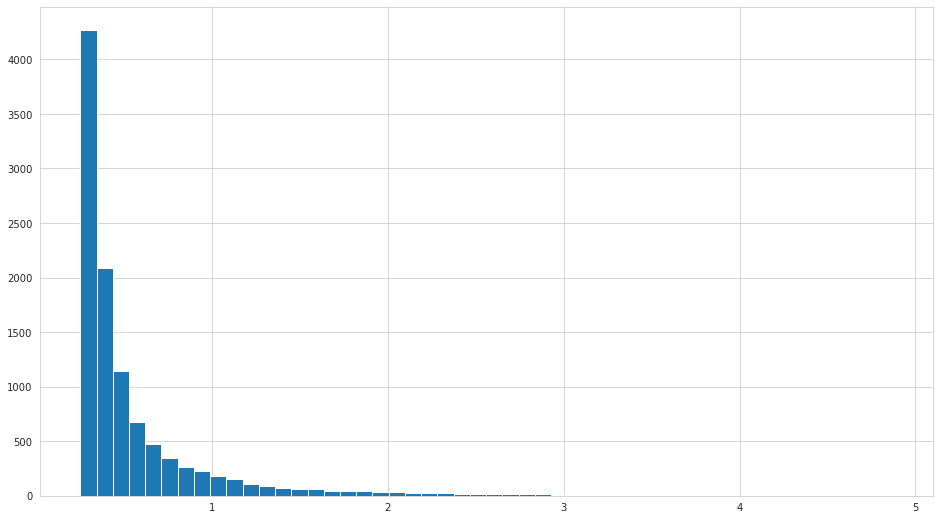

In [8]:
df_new_emiss_25["EW"].hist(bins=50)

In [9]:
df_new_emiss_25["EW"].describe()

count    10625.000000
mean         0.548869
std          0.456927
min          0.250038
25%          0.298722
50%          0.382098
75%          0.586963
max          4.866757
Name: EW, dtype: float64

In [21]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])
hf_grid.close()

In [10]:
df_new_emiss_25.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1541,1542,1543,1544,1545,1546,1547,1548,1549,EW
184,131116000501238,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,...,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,0.354939
344,131116001001352,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,...,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,2.129203
354,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,1.298985
415,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,1.134192
463,131118002901020,1.046427,1.066219,1.111588,1.128791,1.090689,1.048772,1.042966,1.068899,1.107123,...,1.042947,1.040967,1.009793,0.985055,1.007708,1.053111,1.064764,1.036411,1.008668,0.515890


In [11]:
part_70 = df_new_emiss_25.sample(frac=0.7)

In [12]:
rest_part_70 = df_new_emiss_25.drop(part_70.index)

In [13]:
part_70["sobject_id"].count()

7437

In [14]:
rest_part_70["sobject_id"].count()

3188

In [15]:
part_70_data_only = part_70.drop(columns=['EW','sobject_id'])
rest_part_70_data_only = rest_part_70.drop(columns=['EW','sobject_id'])

In [16]:
part_70_data_only_np = part_70_data_only.to_numpy()
rest_part_70_data_only_np = rest_part_70_data_only.to_numpy()

In [17]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [18]:
distance_matrix_rest_70 = sd.pdist(rest_part_70_data_only_np, my_fastdtw)

DTAI Test 

In [11]:
df_new_emiss_25_data_only = df_new_emiss_25.drop(columns=['EW','sobject_id'])

In [28]:
df_new_emiss_25_data_only_np = df_new_emiss_25_data_only.to_numpy()

In [36]:
df_new_emiss_25_data_only_np 

array([[0.87320698, 0.80486417, 0.75710211, ..., 0.83725686, 0.77092758,
        0.80247988],
       [1.09407488, 1.08218396, 1.08878676, ..., 1.0592302 , 1.07122224,
        1.06735063],
       [1.01678956, 1.03371707, 1.03914097, ..., 1.03687289, 1.03514419,
        1.02727585],
       ...,
       [0.94561305, 0.95529801, 0.95642351, ..., 0.98031624, 0.97986543,
        0.97534186],
       [0.88873024, 0.89373349, 0.89334104, ..., 0.90736213, 0.92713406,
        0.93360296],
       [1.00063831, 0.9984654 , 0.99834629, ..., 1.0575973 , 1.07601055,
        1.07484511]])

In [37]:
from dtaidistance import dtw
ds = dtw.distance_matrix_fast(df_new_emiss_25_data_only_np )

In [38]:
ds

array([[0.        , 4.17040913, 3.09822439, ..., 1.80268937, 1.83746225,
        1.9162478 ],
       [4.17040913, 0.        , 5.14256966, ..., 6.83805   , 7.17756957,
        6.31816426],
       [3.09822439, 5.14256966, 0.        , ..., 1.79685294, 1.82795859,
        1.68728177],
       ...,
       [1.80268937, 6.83805   , 1.79685294, ..., 0.        , 0.34009036,
        0.38831614],
       [1.83746225, 7.17756957, 1.82795859, ..., 0.34009036, 0.        ,
        0.77785053],
       [1.9162478 , 6.31816426, 1.68728177, ..., 0.38831614, 0.77785053,
        0.        ]])

In [39]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

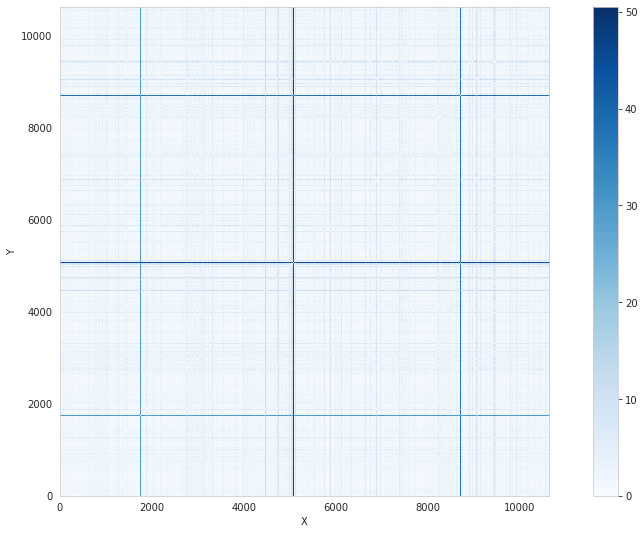

In [40]:
distance_cost_plot(ds)

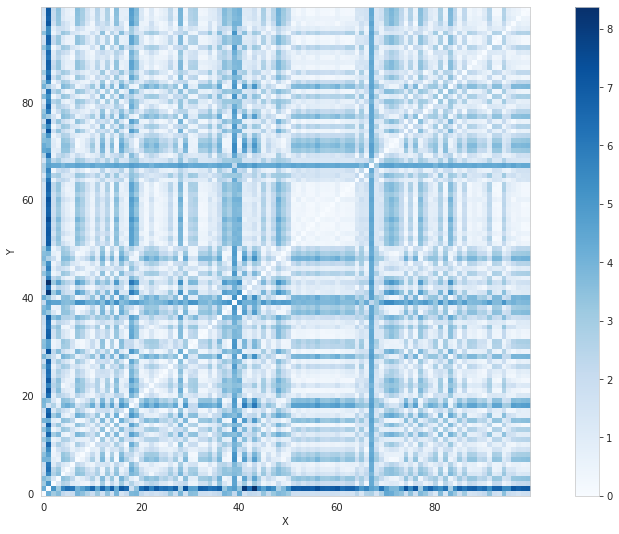

In [41]:
distance_cost_plot(ds[0:100:,0:100])

In [80]:
agglom = AgglomerativeClustering(n_clusters = 20, linkage = 'complete', affinity='precomputed')
agglom.fit(ds)
agglom.labels_

array([2, 6, 2, ..., 2, 2, 2])

In [81]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [82]:
score = silhouette_score(df_new_emiss_25_data_only_np , agglom.labels_)
print(score)

0.40248513867982344


In [83]:
old_names = df_new_emiss_25_data_only.columns.tolist()

In [84]:
new_names = wl_grid[PLOT_MASK].tolist()

In [85]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [86]:
df_new_emiss_25_data_only.rename(columns=col_rename_dict, inplace=True)

In [87]:
df_new_emiss_25_data_only

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.819911,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.087653,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.059578,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.956748,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347
463,1.046427,1.066219,1.111588,1.128791,1.090689,1.048772,1.042966,1.068899,1.107123,1.134540,...,1.060275,1.042947,1.040967,1.009793,0.985055,1.007708,1.053111,1.064764,1.036411,1.008668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.030614,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.103199,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.977026,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.889530,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603


In [88]:
df_new_emiss_25_data_only["label"] = pd.Series(agglom.labels_, index = df_new_emiss_25_data_only.index)

In [89]:
df_new_emiss_25_data_only

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,2
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,6
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,2
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,2
463,1.046427,1.066219,1.111588,1.128791,1.090689,1.048772,1.042966,1.068899,1.107123,1.134540,...,1.042947,1.040967,1.009793,0.985055,1.007708,1.053111,1.064764,1.036411,1.008668,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831,2
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375,2
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342,2
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603,2


In [90]:
df_new_emiss_25_data_only["label"].value_counts()

2     9831
8      216
0      206
6      187
4       95
16      22
3       13
7       11
18      11
10       7
1        6
15       4
13       4
5        3
9        2
12       2
11       2
17       1
14       1
19       1
Name: label, dtype: int64

Int64Index([156355, 157339, 206598, 275988, 277052, 280168, 280390, 281430,
            281458, 281572, 281722, 281822, 281865, 282499, 282848, 283043,
            283421, 477676, 477881, 478453, 559988, 560134],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

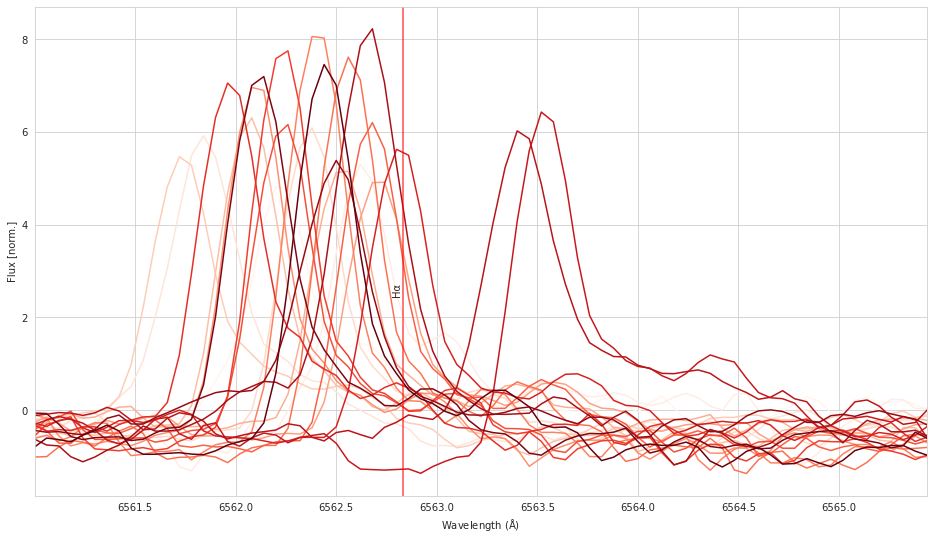

In [100]:
CLASS = 16
df_masked_label = df_new_emiss_25_data_only.loc[df_new_emiss_25_data_only["label"]==CLASS]
print(df_masked_label.index)
ax = (df_new_emiss_25_data_only.loc[df_new_emiss_25_data_only['label'] == CLASS].drop(columns=['label']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Reds"
    )
halpha_line = ax.axvline(x=6562.83, color='red', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)